Clicca runtime->esegui tutte

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import joblib 

In [3]:
def to_float(a):
    return np.array(a[1:-1].split(',')).astype(float)



In [4]:
# %cd "gdrive/My Drive/thesis/Colab Notebooks"

In [5]:
#!pip install import-ipynb
#!pip install shapely

In [6]:
import import_ipynb 
from pattern1 import Pattern1
from pattern2 import Pattern2
from pattern3 import Pattern3
from pattern4 import Pattern4
from pattern5 import Pattern5
from pattern6 import Pattern6
from pattern7 import Pattern7
from pattern8 import Pattern8
from pattern9 import Pattern9
from pattern10 import Pattern10
from pattern11 import Pattern11
from pattern12 import Pattern12
from pattern13 import Pattern13
from pattern14 import Pattern14
from pattern15 import Pattern15
from pattern16 import Pattern16
from pattern17 import Pattern17
from pattern18 import Pattern18

importing Jupyter notebook from pattern1.ipynb
x-diag[0][0]) -20
x-diag[0][0]) 255
x-diag[0][0]) 490
x-diag[0][0]) 20
x-diag[0][0]) -255
x-diag[0][0]) -215
x-diag[0][0]) -490
importing Jupyter notebook from pattern2.ipynb
importing Jupyter notebook from pattern3.ipynb
importing Jupyter notebook from pattern4.ipynb
importing Jupyter notebook from pattern5.ipynb
importing Jupyter notebook from pattern6.ipynb
importing Jupyter notebook from pattern7.ipynb
importing Jupyter notebook from pattern8.ipynb
importing Jupyter notebook from pattern9.ipynb
importing Jupyter notebook from pattern10.ipynb
importing Jupyter notebook from pattern11.ipynb
importing Jupyter notebook from pattern12.ipynb
importing Jupyter notebook from pattern13.ipynb
importing Jupyter notebook from pattern14.ipynb
importing Jupyter notebook from pattern15.ipynb
importing Jupyter notebook from pattern16.ipynb
importing Jupyter notebook from pattern17.ipynb
importing Jupyter notebook from pattern18.ipynb


In [7]:
from shapely.geometry import Polygon, Point, LineString
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from skimage.morphology import skeletonize
import cv2
from matplotlib import pyplot as plt

# transform the black zones resulted from the homography transformation in the color of the paper
def unique_color(img):
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.show()

    #create a mask that has False for every pixel that corresponds to black (0) and True for all pixels that are colored
    mask = img > 0
    print(mask)
    #select only the colored pixels in a new array
    only_color = img[mask]
    print(only_color)

    #identify all unique colors that were used (unique values of pixels), and for each return their number 
    colors, count = np.unique(only_color, return_counts=True)

    #get the color that had the maximum number of occurences in the image
    max_color = colors[count.argmax()]
    print(max_color)
    #assign to all the pixels that are false in the mask (meaning the black, 0, pixels) the value of the max_color (which usually is that of the page);
    #in this way we can make the black margins that resulted from the homography become "white"
    img[np.logical_not(mask)] = max_color

    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    return img

def computeHomographyRhomb(points):
    p_dst = [(382, 219), (852, 219), (852, 537), (382, 537)]
    #add 1 to the tuple of the point with index 2, which is representing the point that has to be adiacent to the rhomb
    point_rhomb = points[2] + (1,)
    #make a mask for all points and set them all on true (1) except for the rhomb point, which gets false(0)
    mask = np.ones(5, dtype=int)
    mask[2] = 0
    #select all the points with the exception of the point with the rhomb, excluded by the mask
    right_points = np.array(points)[np.ma.make_mask(mask)]
    #find the homography transformation matrix between the 4 points of the rectangle of the patient image, and the corresponding points on the example tamplate that we are using; the points are hardcodded in p_dst
    hm, status = cv2.findHomography(np.array(right_points), np.array(p_dst))
    #generate the new point corresponding to the rhomb positioning using the homography matrix
    new_point = np.dot(hm, point_rhomb)
    #transform the point in order to have the third coordinate = 1 => you split by it
    new_point = tuple(np.round(new_point / new_point[2]).astype(int))
    # select the elements between 0 (the first) and 2 (the last) BUT not including the last
    center = new_point[0:2]
    return center


def find_line(img_path):

    # identify the 5 points of interest the homogram 
    points = np.array(file_homog.loc[img_path[:-4]].to_numpy()[0])
    if points.shape == (1,):
        points = np.array(points[0])
    #transform points from a matrix into an array of tuples
    points = [tuple(x) for x in points]

    #compute the homography for the point corresponding to the rhomb
    r_points = computeHomographyRhomb(points)

    # transform the black zones resulted from the homography transformation in the color of the paper
    img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
    #img = cv2.blur(img, (3, 3))

    #initialize the drawing as an array of 0s, in the shape of the image + 3 
    drawing = np.zeros((img.shape[0], img.shape[1], 3))
    #initialize the score result with 0s
    results = np.zeros(18)

    # [STUDIED] Generate score for Pattern 2 (mostly computer vision, + SVM prediction)
    pat2 = Pattern2(img, drawing, joblib.load('../rectangle_model.joblib'), joblib.load('../rectangle_scaler.joblib'))
    print(joblib.load('../rectangle_model.joblib'))
    print(joblib.load('../rectangle_scaler.joblib'))
    # get the drawing that contains the idenitfied lines and the polygon, with the circles drawn in its corners
    # get the resulted score
    # return the figure as a tuple: first is the polygon shape, and the second is the corners (vertices)
    drawing, results[1], ret_fig = pat2.get_score()
    print(ret_fig)

    #Generate score for Pattern 1 [ANALYTICAL] [COMPUTER VISION]
    # img - initial image; drawing - generated drawing after the initia image
    pat1 = Pattern1(img, drawing)    
    # TODO: explain what is returned
    drawing, results[0], diag1, diag2 = pat1.get_score(ret_fig)
    
    # pat6 = Pattern6(img, drawing)
    # drawing, results[5], oriz_coord = pat6.get_score(ret_fig, diag1, diag2)    
    # pat3 = Pattern3(img, drawing, joblib.load('../rett_diag_model.joblib'), joblib.load('../rett_diag_scaler.joblib'), joblib.load('../rett_diag_score_model.joblib'), joblib.load('../rett_diag_score_scaler.joblib'), img_path)
    # drawing, results[2] = pat3.get_score(ret_fig, diag1, diag2, oriz_coord)      
    # pat5 = Pattern5(img, drawing, joblib.load('../cross_model.joblib'), joblib.load('../cross_scaler.joblib'), joblib.load('../cross_score_model.joblib'), joblib.load('../cross_score_scaler.joblib'), img_path)
    # drawing, results[4] = pat5.get_score()    
    # pat4 = Pattern4(img, drawing, diag1, oriz_coord)
    # drawing, results[3] = pat4.get_score(diag1, ret_fig) 
    # pat7 = Pattern7(img, drawing)
    # drawing, results[6], vert = pat7.get_score(ret_fig, diag1, diag2)
    # pat8 = Pattern8(img, drawing, diag1, diag2, vert, oriz_coord)
    # drawing, results[7] = pat8.get_score() 
    # pat9 = Pattern9(img, drawing, vert)
    # drawing, results[8] = pat9.get_score(ret_fig, vert)
    # pat10 = Pattern10(img, drawing, joblib.load('../face_model.joblib'), joblib.load('../face_scaler.joblib'), joblib.load('../face_score_model.joblib'), joblib.load('../face_score_scaler.joblib'), img_path)
    # drawing, results[9] = pat10.get_score(diag2, oriz_coord)
    # pat11 = Pattern11(img, drawing, vert, diag2)
    # drawing, results[10] = pat11.get_score(ret_fig, diag1, diag2)   
    # pat12 = Pattern12(img, drawing, joblib.load('../rail_model.joblib'), joblib.load('../rail_scaler.joblib'), joblib.load('../rail_score_model.joblib'), joblib.load('../rail_score_scaler.joblib'), img_path)
    # drawing, results[11] = pat12.get_score()
    # pat13 = Pattern13(img, drawing, r_points, ret_fig)
    # drawing, results[12] = pat13.get_score()       
    # pat14 = Pattern14(img, drawing, r_points)
    # drawing, results[13], rhomb_fig = pat14.get_score(r_points, diag1, diag2)
    # pat15 = Pattern15(img, drawing, joblib.load('../rect_model.joblib'), joblib.load('../rect_scaler.joblib'), joblib.load('../rect_score_model.joblib'), joblib.load('../rect_score_scaler.joblib'), img_path)
    # drawing, results[14] = pat15.get_score(ret_fig)
    # pat16 = Pattern16(img, drawing, r_points)
    # drawing, results[15] = pat16.get_score(ret_fig, oriz_coord, r_points)
    # pat17 = Pattern17(img, drawing, joblib.load('../cross_vert_model.joblib'), joblib.load('../cross_vert_scaler.joblib'), joblib.load('../cross_vert_score_model.joblib'), joblib.load('../cross_vert_score_scaler.joblib'), img_path)
    # drawing, results[16] = pat17.get_score()
    # pat18 = Pattern18(img, drawing, joblib.load('../triang_model.joblib'), joblib.load('../triang_scaler.joblib'), joblib.load('../triang_score_model.joblib'), joblib.load('../triang_score_scaler.joblib'), img_path)
    # drawing, results[17] = pat18.get_score()
    #plt.imshow(drawing)
    #plt.show()    

    # convert image from grayscale to RGB
    overlap = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # extract from a generated image that contains true (1, white) for all the pixels in the drawing that is different than 0 (black), the pixels that follow the mask that is true for any pixel from the drawing that is different than green (which is usually the contour of the drawing)  
    drawing_mask = np.bitwise_and(np.any(drawing != [0, 0, 0], axis=-1), np.any(drawing != [0, 255, 0], axis=-1))
    # on the colored version of the image, put on the pixels saved on the drawing mask the pixels taken from the generated drawing that contains the analysis and patterns detected
    overlap[drawing_mask] = drawing[drawing_mask]
    plt.imshow(overlap)
    plt.show()    
    #return the results list from the analysis of all the patterns
    return results.astype(np.uint8)
    



['PATTERN1' 'PATTERN2' 'PATTERN3' 'PATTERN4' 'PATTERN5' 'PATTERN6'
 'PATTERN7' 'PATTERN8' 'PATTERN9' 'PATTERN10' 'PATTERN11' 'PATTERN12'
 'PATTERN13' 'PATTERN14' 'PATTERN15' 'PATTERN16' 'PATTERN17' 'PATTERN18']
Immagini-59.png


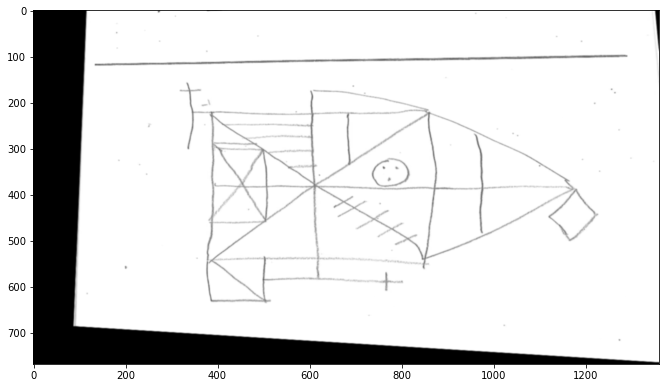

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[165 247 252 ... 255   8  32]
255


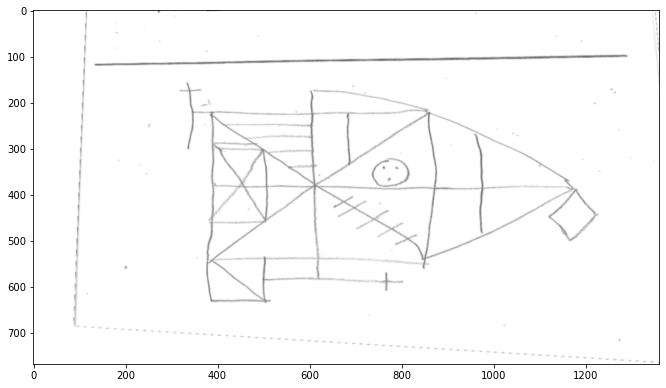

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
StandardScaler(copy=True, with_mean=True, with_std=True)


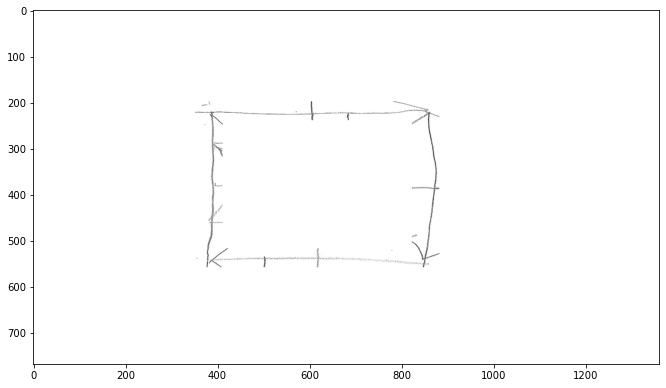

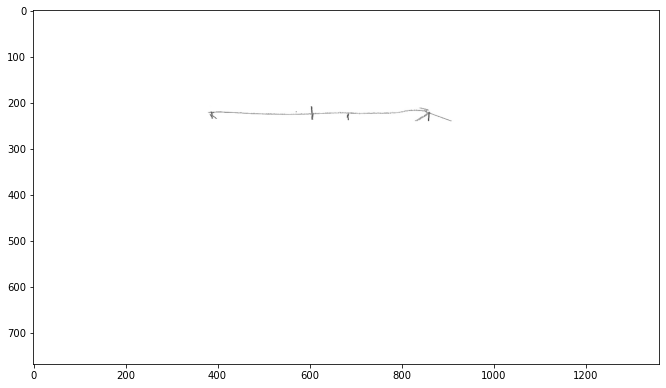

line1:  ((380, 222), (910, 224))


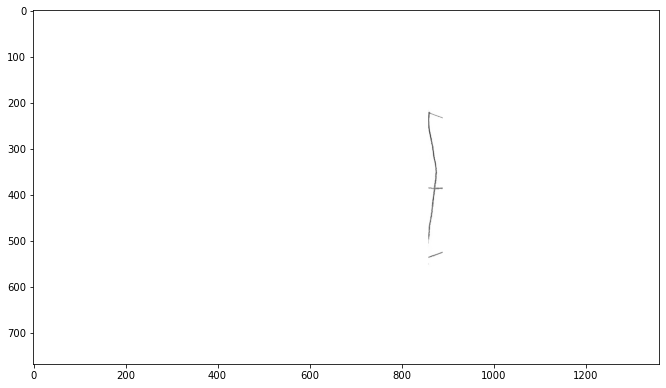

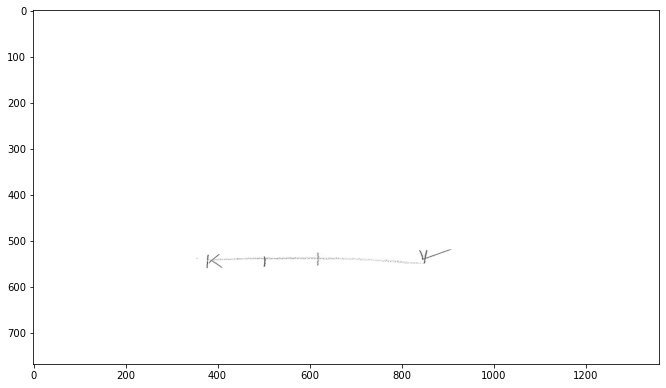

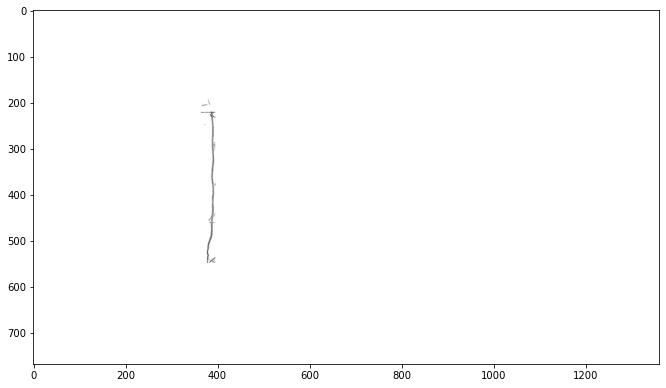

rect_ext [[380 221]
 [874 227]
 [874 532]
 [380 547]]
ret POLYGON ((378.5 221, 378.5 547, 378.5075045320832 547.149857526497, 378.5299430376638 547.2982155721734, 378.5670909960949 547.4435896600776, 378.6185767033156 547.5845251708674, 378.6838849911368 547.7196118977929, 378.7623623820371 547.8474981572859, 378.8532236278857 547.9669043139631, 378.9555595671702 548.0766355847129, 379.0683462221041 548.1755939937462, 379.1904550445936 548.262789358989, 379.3206642085372 548.3373491998867, 379.4576708354707 548.3985274674817, 379.6001040312239 548.4457120094115, 379.7465386031473 548.478430695131, 379.89550932065 548.4963561400713, 380.0455255763602 548.4993089814635, 874.0455255763602 533.4993089814635, 874.1894416809715 533.4879891967049, 874.3316031360927 533.4628873367876, 874.4706932118283 533.4242359005231, 874.605423626058 533.3723928858059, 874.7345464767814 533.3078384737604, 874.8568658004542 533.2311705811998, 874.9712486492596 533.1430993225925, 875.0766355847129 533.044440

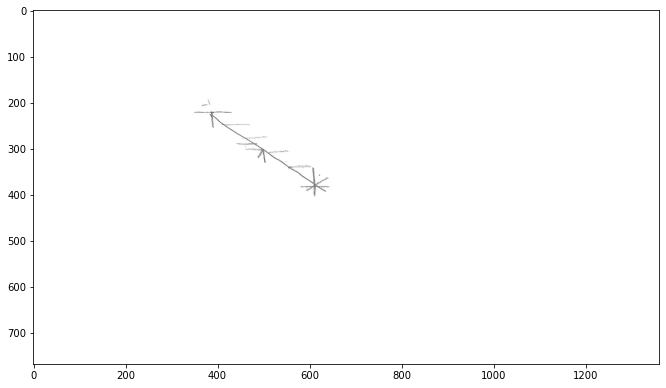

[(376, 223), (591, 409), (623, 373), (408, 187)]


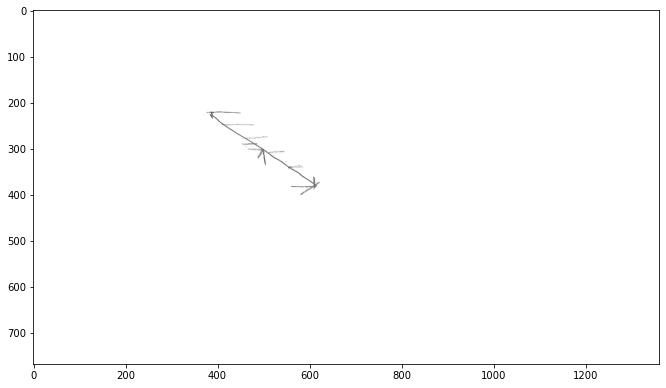

[(320, 226), (655, 412), (679, 370), (344, 184)]


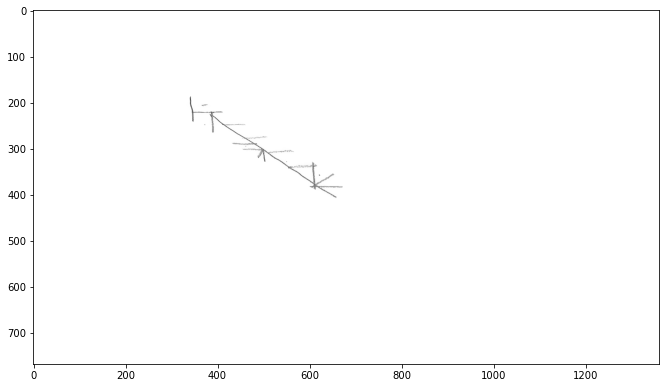

[(368, 225), (643, 411), (671, 371), (396, 185)]


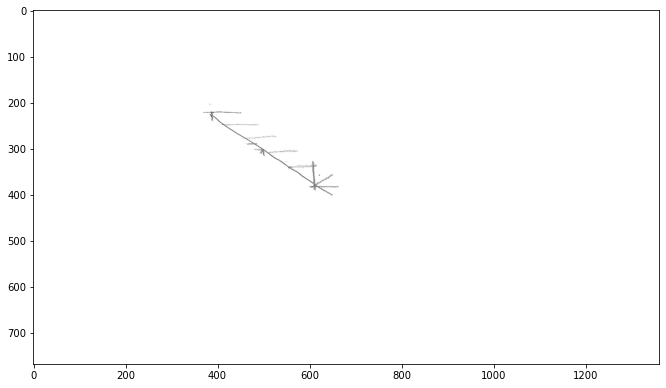

[(396, 223), (611, 409), (643, 373), (428, 187)]


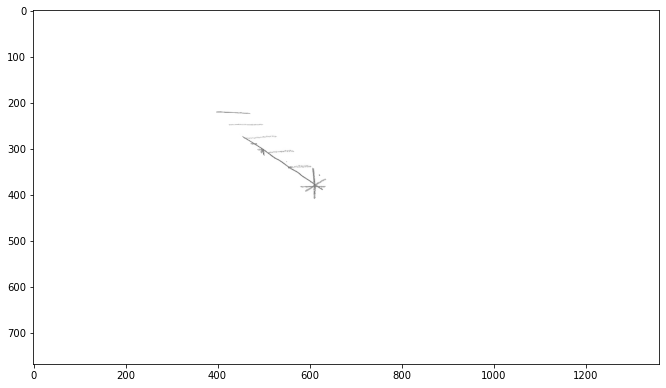

[(340, 226), (675, 412), (699, 370), (364, 184)]


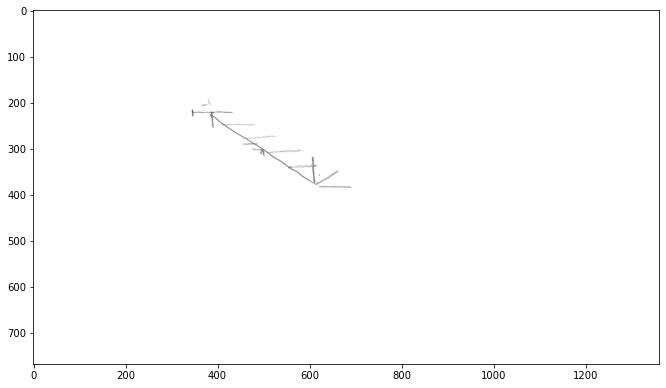

[(388, 225), (663, 411), (691, 371), (416, 185)]


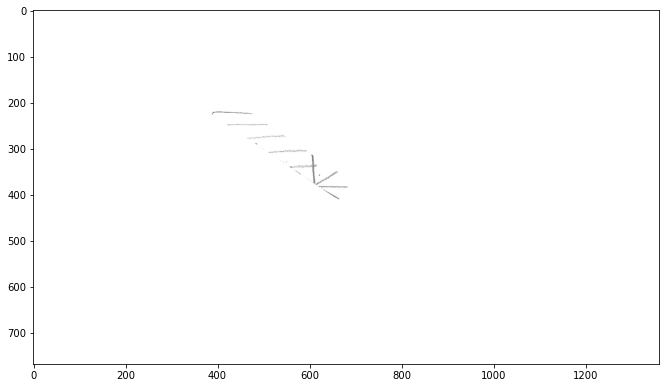

[(416, 223), (631, 409), (663, 373), (448, 187)]


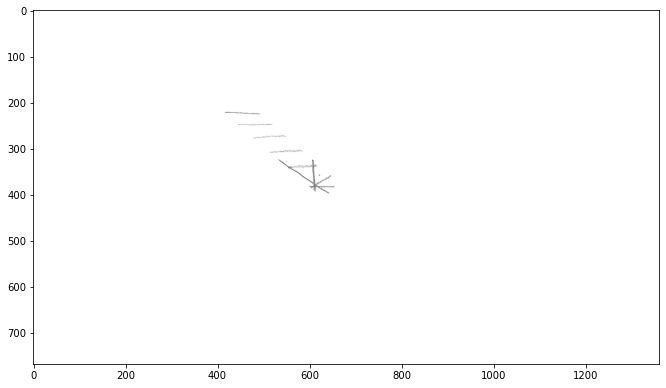

[(360, 226), (695, 412), (719, 370), (384, 184)]


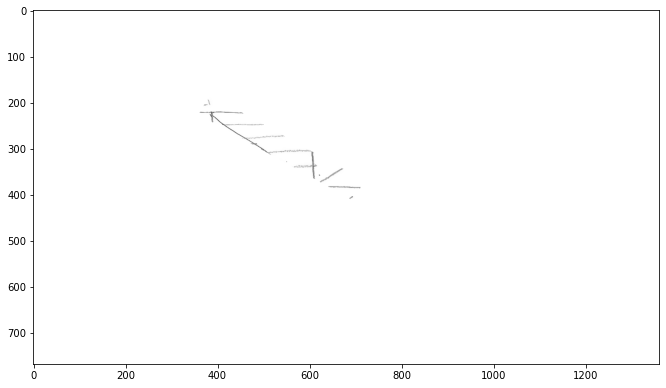

[(408, 225), (683, 411), (711, 371), (436, 185)]


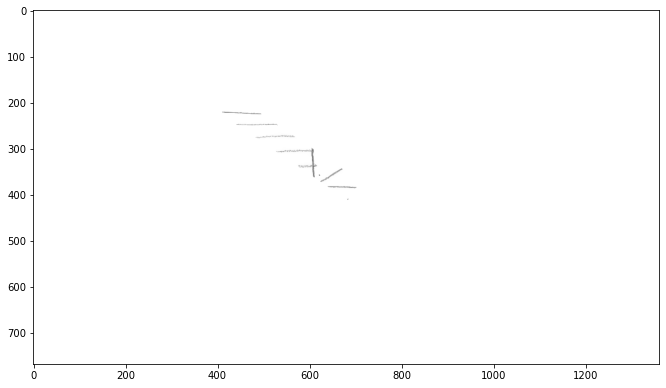

[(436, 223), (651, 409), (683, 373), (468, 187)]


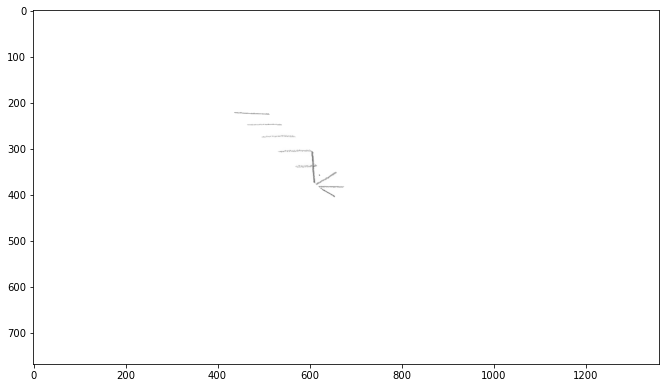

[(380, 226), (715, 412), (739, 370), (404, 184)]


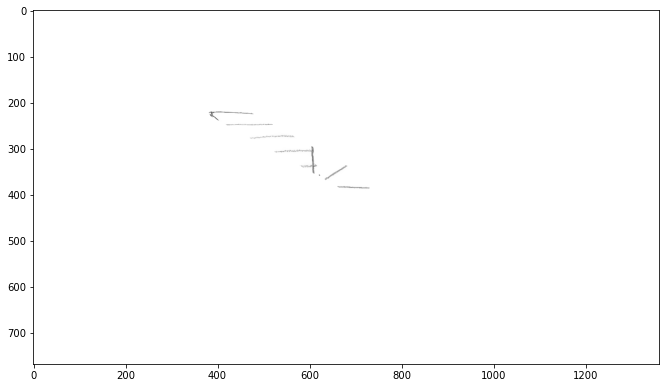

[(428, 225), (703, 411), (731, 371), (456, 185)]


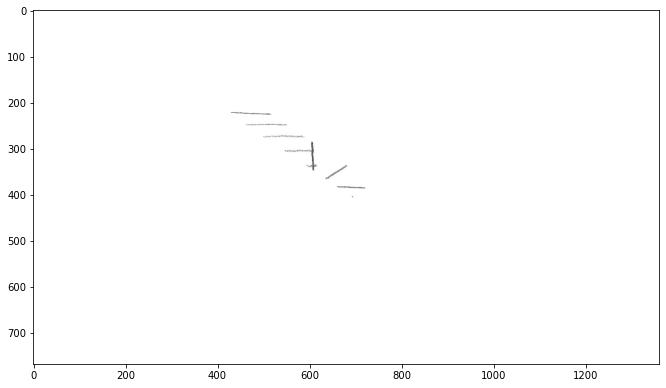

[(456, 223), (671, 409), (703, 373), (488, 187)]


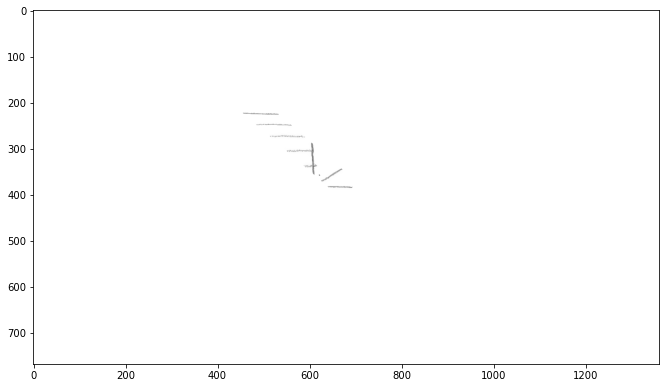

[(400, 226), (735, 412), (759, 370), (424, 184)]


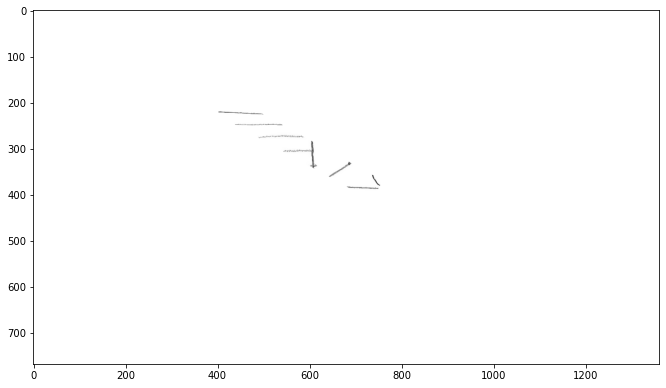

[(448, 225), (723, 411), (751, 371), (476, 185)]


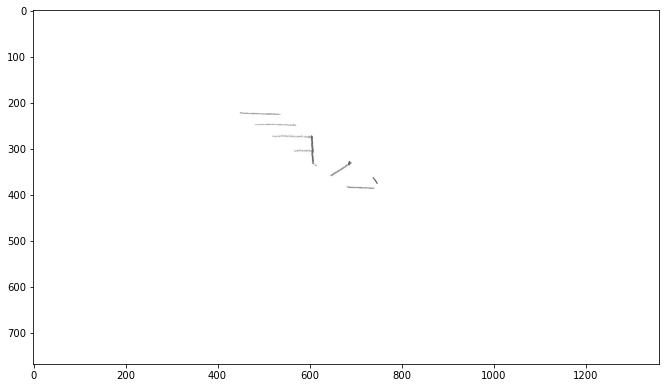

[(476, 223), (691, 409), (723, 373), (508, 187)]


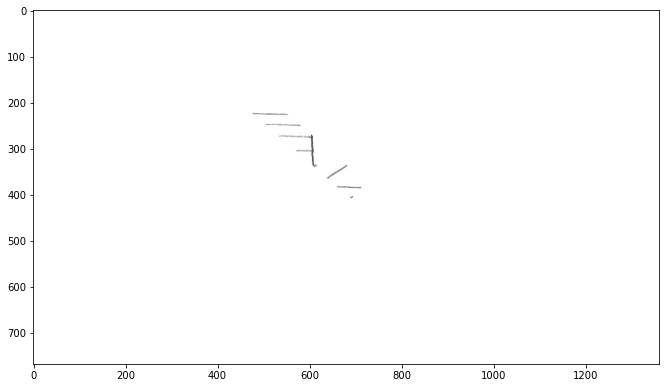

[(420, 226), (755, 412), (779, 370), (444, 184)]


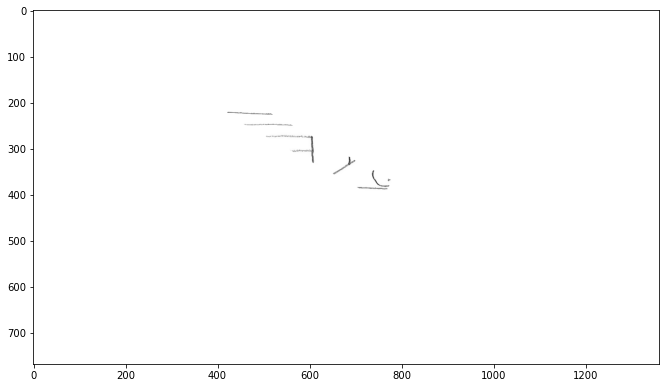

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
coverage 87.78877887788778 75.66371681415929
coverage 96.35627530364373 69.36936936936937
coverage 88.3008356545961 94.2982456140351
coverage 92.07920792079209 79.64601769911505
coverage 72.06477732793523 53.6036036036036
coverage 77.71587743732591 67.98245614035088
coverage 58.415841584158414 51.76991150442478
coverage 46.15384615384615 34.234234234234236
coverage 53.2033426183844 51.75438596491229
coverage 15.181518151815181 12.389380530973451
coverage 13.370473537604457 12.719298245614036
coverage 14.85148514851485 11.946902654867257
coverage 16.599190283400812 11.26126126126126
coverage 14.206128133704734 13.157894736842104
coverage 14.521452145214523 11.946902654867257
coverage 18.62348178137652 12.612612612612612
coverage 13.92757660167131 13.157894736842104
draw_contours______________


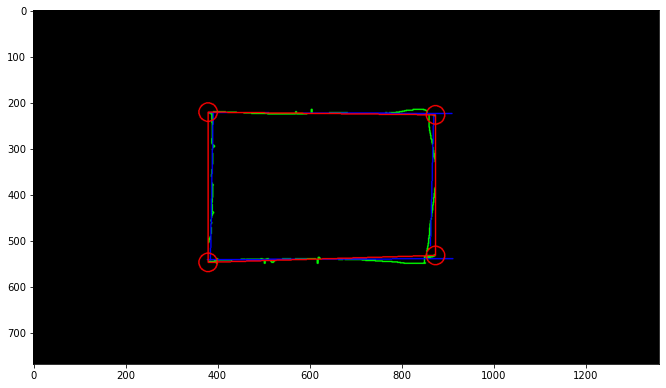

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


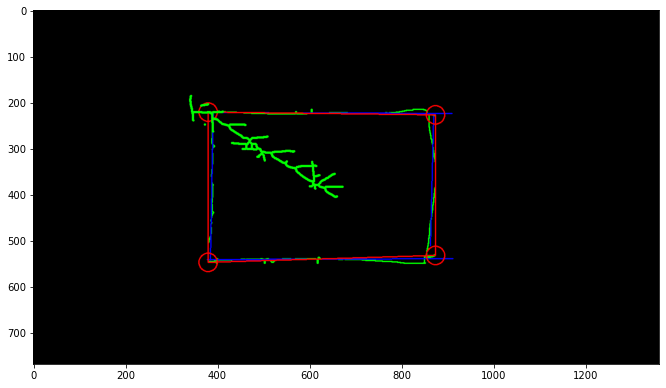

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


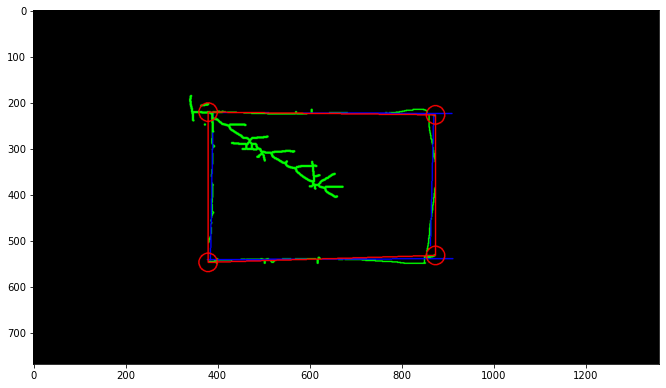

arctan2 + rad2deg 33.144409932564066
I am here
[(623, 411), (858, 570), (886, 530), (651, 371)]


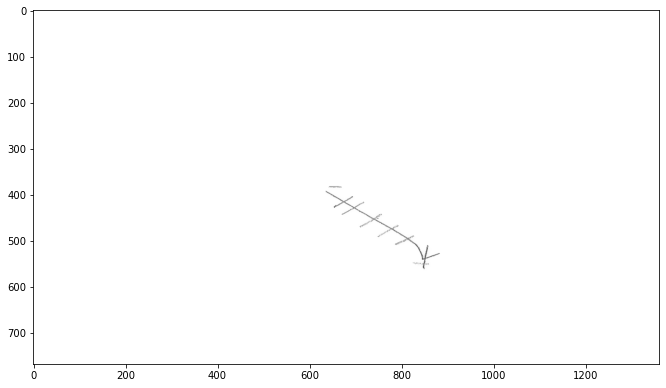

[(651, 409), (826, 568), (858, 532), (683, 373)]


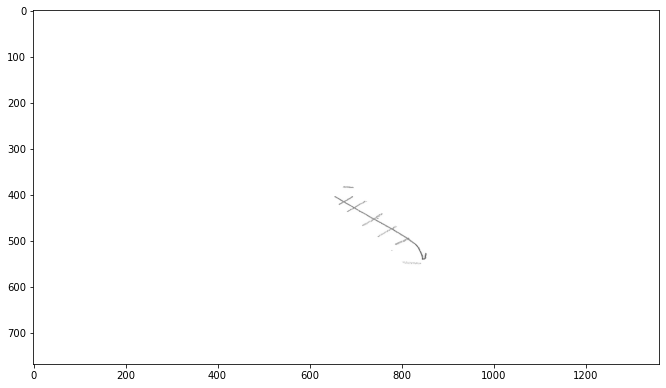

[(596, 413), (891, 572), (913, 528), (618, 369)]


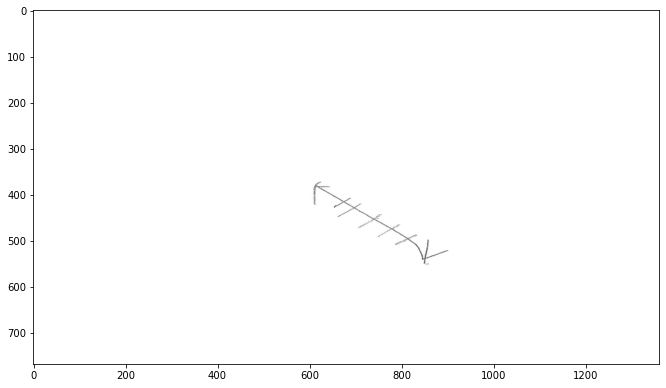

[(643, 411), (878, 570), (906, 530), (671, 371)]


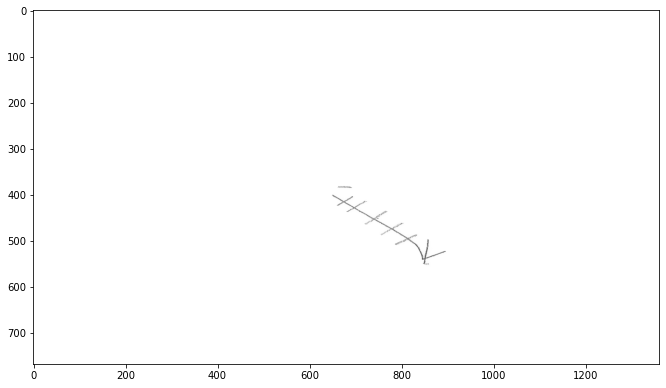

[(671, 409), (846, 568), (878, 532), (703, 373)]


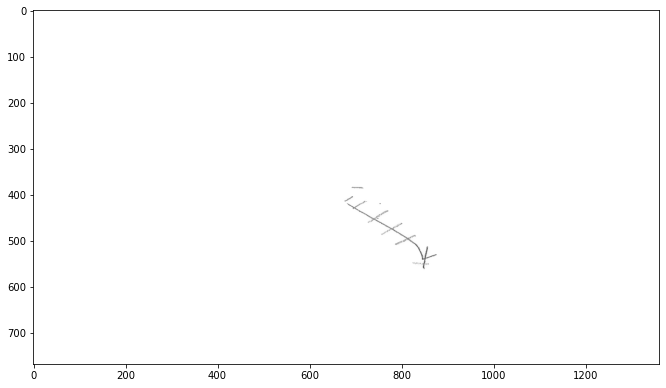

[(616, 413), (911, 572), (933, 528), (638, 369)]


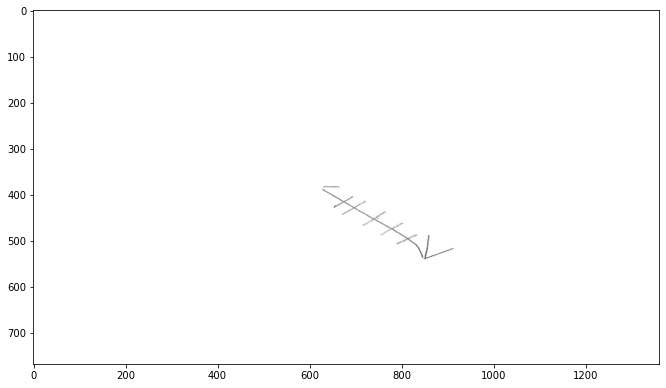

[(663, 411), (898, 570), (926, 530), (691, 371)]


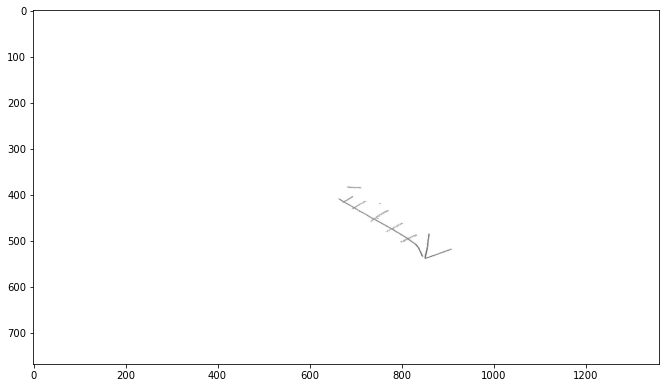

[(691, 409), (866, 568), (898, 532), (723, 373)]


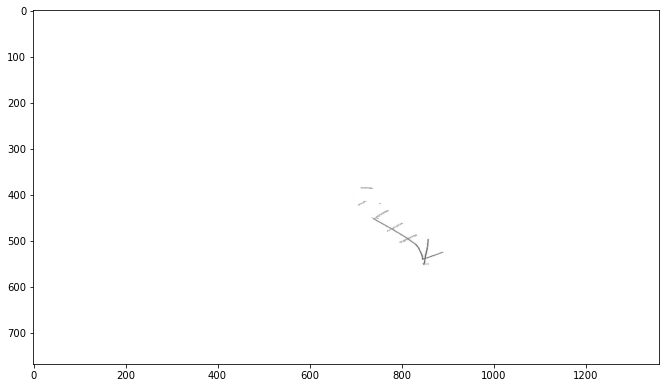

[(636, 413), (931, 572), (953, 528), (658, 369)]


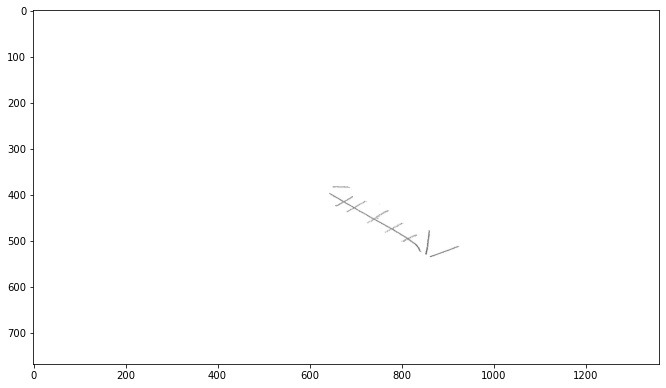

[(683, 411), (918, 570), (946, 530), (711, 371)]


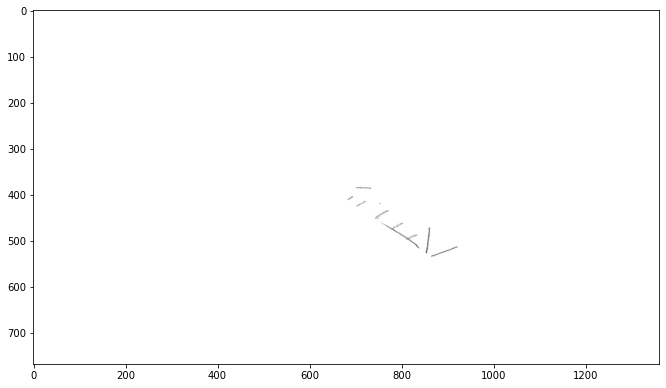

[(711, 409), (886, 568), (918, 532), (743, 373)]


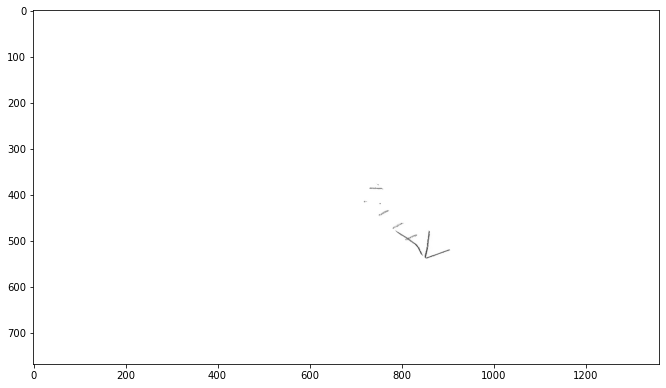

[(656, 413), (951, 572), (973, 528), (678, 369)]


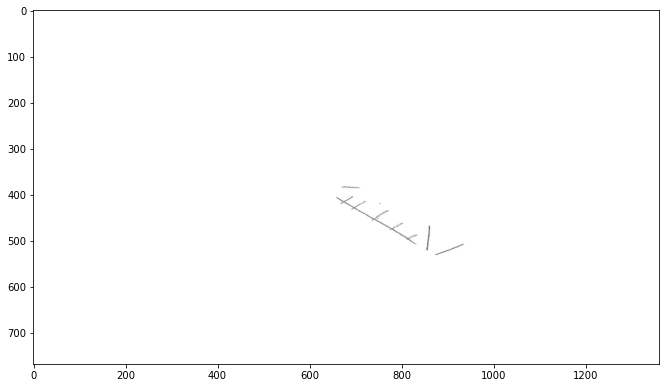

[(703, 411), (938, 570), (966, 530), (731, 371)]


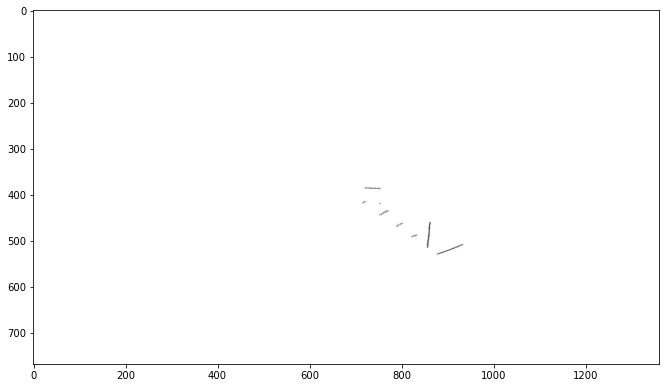

[(731, 409), (906, 568), (938, 532), (763, 373)]


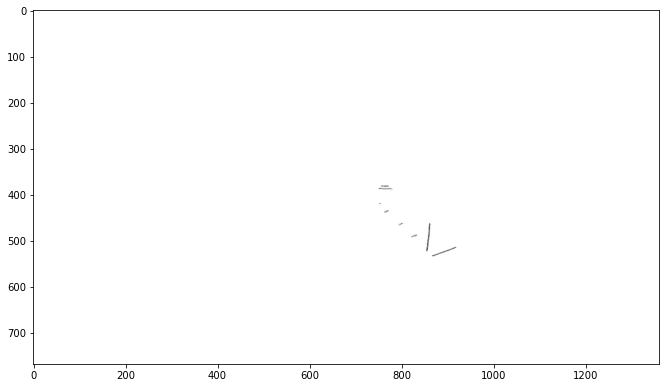

[(676, 413), (971, 572), (993, 528), (698, 369)]


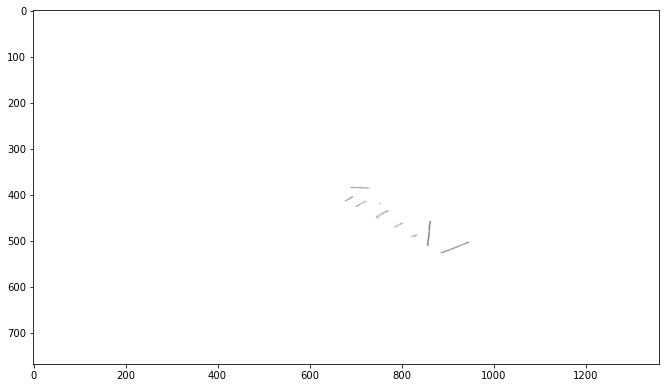

[(723, 411), (958, 570), (986, 530), (751, 371)]


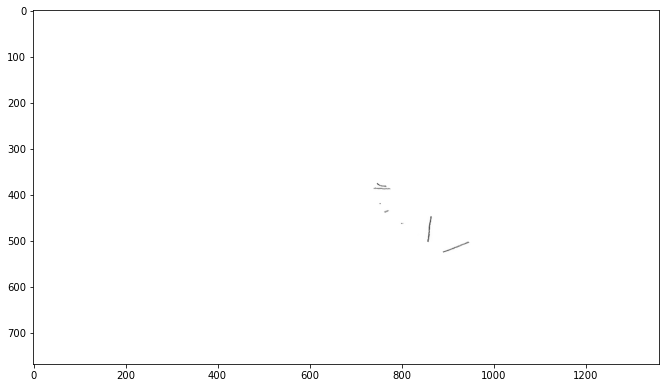

[(751, 409), (926, 568), (958, 532), (783, 373)]


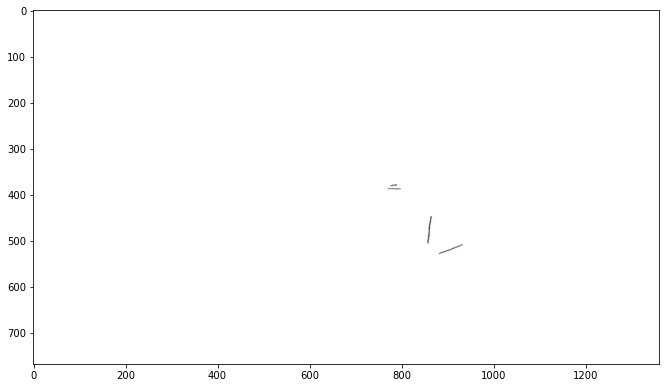

[(696, 413), (991, 572), (1013, 528), (718, 369)]


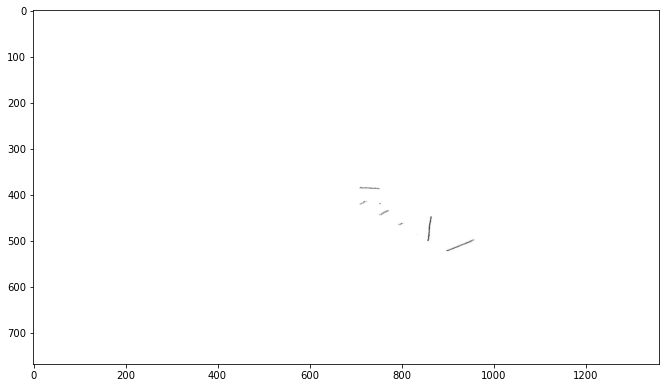

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
coverage 88.212927756654 71.35678391959799
coverage 82.6086956521739 50.76923076923077
coverage 67.82334384858044 61.57635467980296
coverage 70.72243346007605 54.2713567839196
coverage 89.3719806763285 62.56410256410256
coverage 77.28706624605678 70.44334975369459
coverage 79.84790874524715 61.30653266331658
coverage 66.66666666666666 52.820512820512825
coverage 69.08517350157729 67.98029556650246
coverage 48.669201520912544 42.211055276381906
coverage 40.09661835748793 29.743589743589745
coverage 75.39432176656152 62.06896551724138
coverage 23.193916349809886 12.060301507537687
coverage 20.82018927444795 11.822660098522167
coverage 20.912547528517113 11.055276381909549
coverage 24.154589371980677 9.743589743589745
coverage 19.873817034700316 12.807881773399016
draw_contours______________


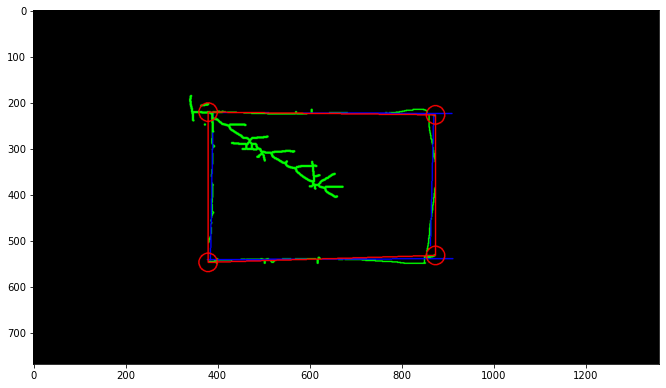

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


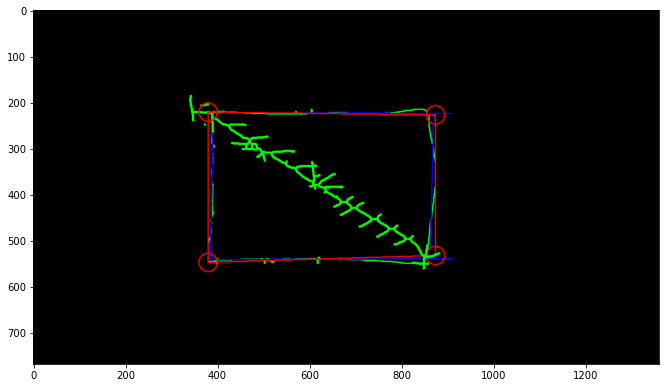

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


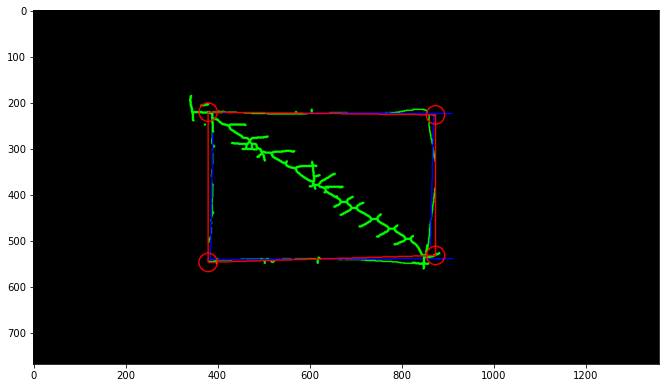

arctan2 + rad2deg 30.01013764031821
[(858, 185), (583, 371), (611, 411), (886, 225)]


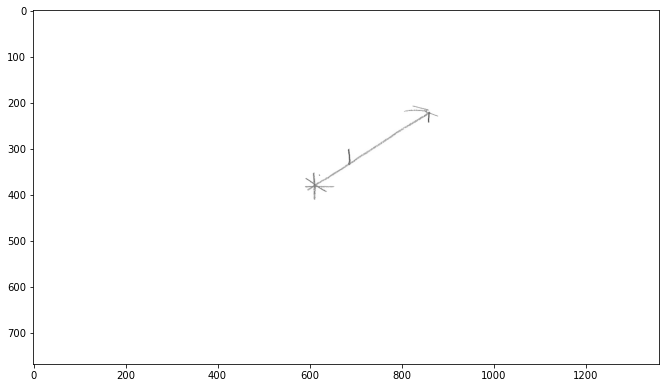

[(890, 184), (555, 370), (579, 412), (914, 226)]


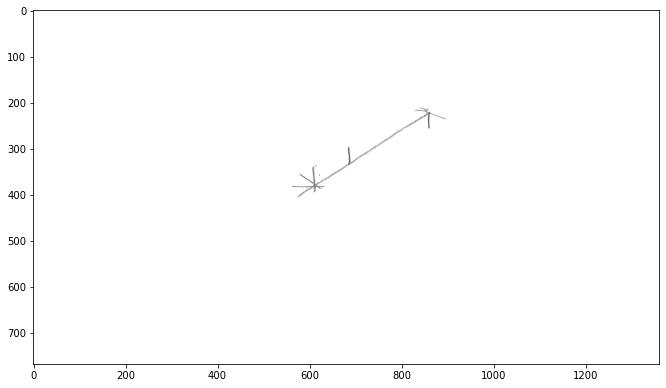

[(826, 187), (611, 373), (643, 409), (858, 223)]


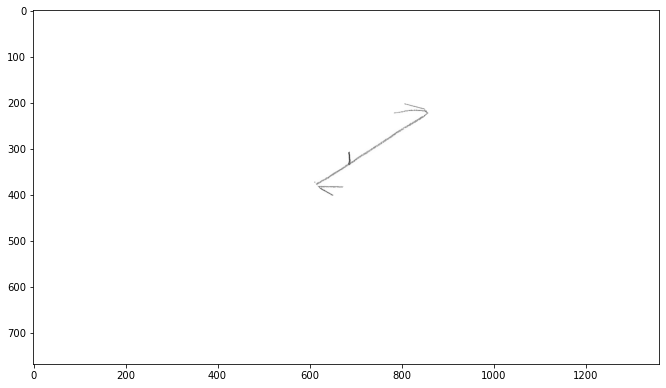

[(838, 185), (563, 371), (591, 411), (866, 225)]


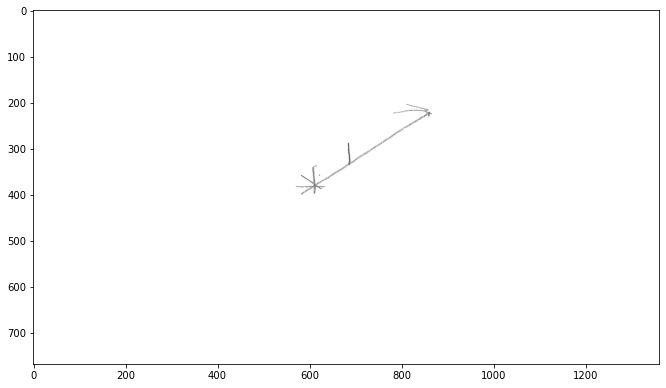

[(870, 184), (535, 370), (559, 412), (894, 226)]


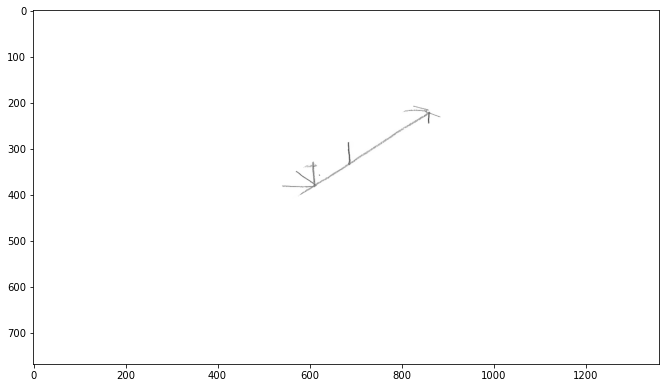

[(806, 187), (591, 373), (623, 409), (838, 223)]


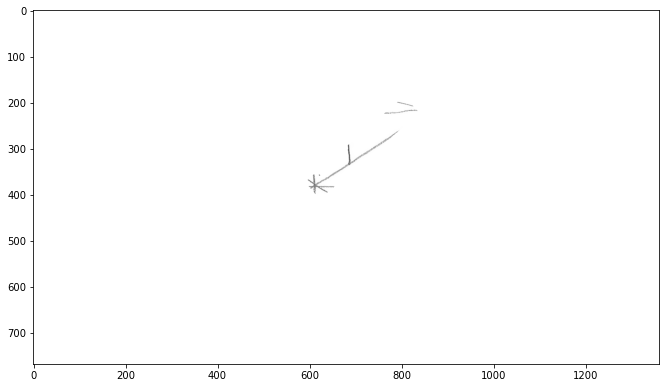

[(818, 185), (543, 371), (571, 411), (846, 225)]


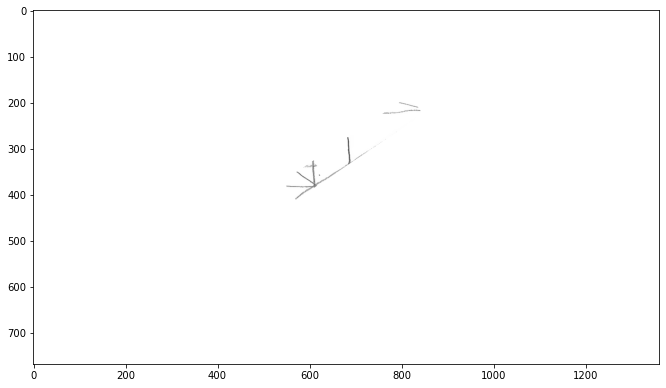

[(850, 184), (515, 370), (539, 412), (874, 226)]


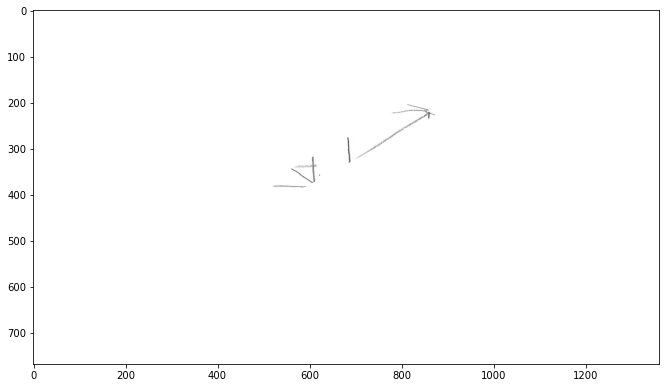

[(786, 187), (571, 373), (603, 409), (818, 223)]


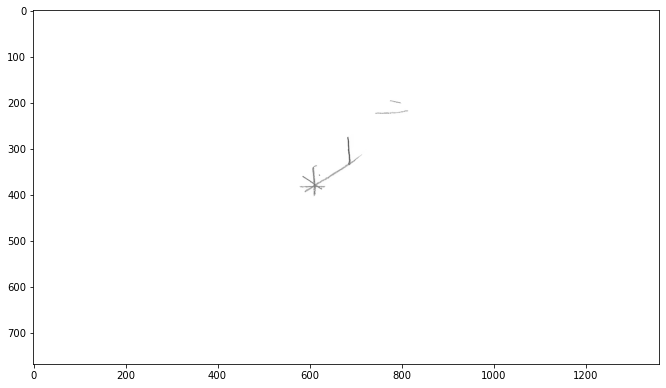

[(798, 185), (523, 371), (551, 411), (826, 225)]


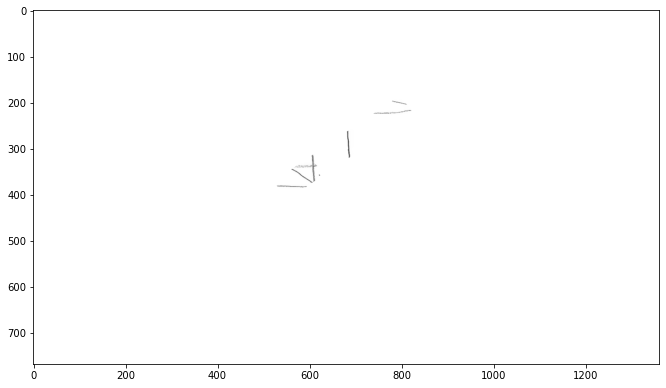

[(830, 184), (495, 370), (519, 412), (854, 226)]


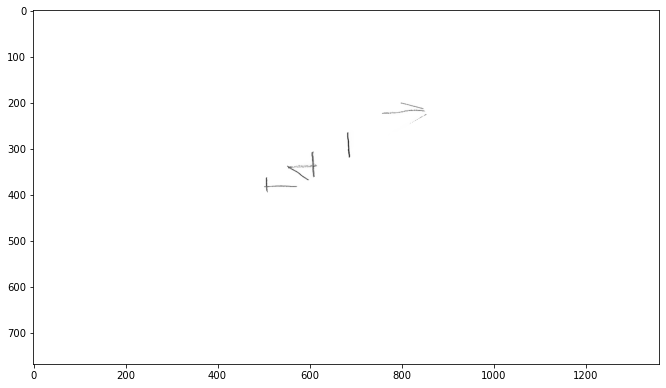

[(766, 187), (551, 373), (583, 409), (798, 223)]


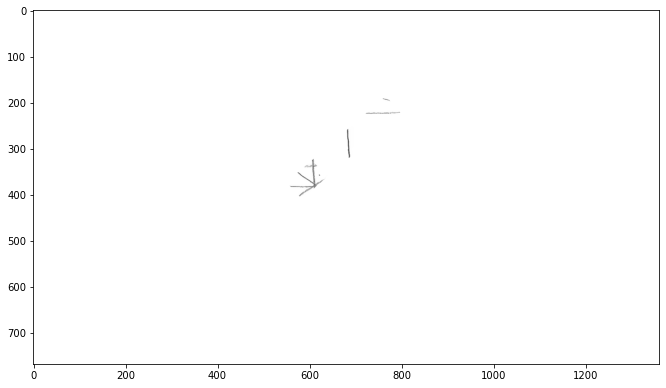

[(778, 185), (503, 371), (531, 411), (806, 225)]


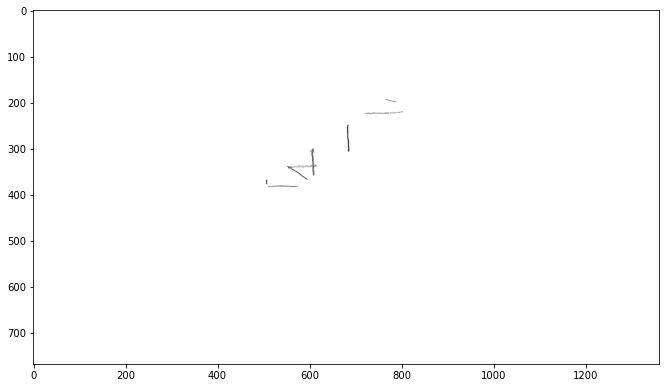

[(810, 184), (475, 370), (499, 412), (834, 226)]


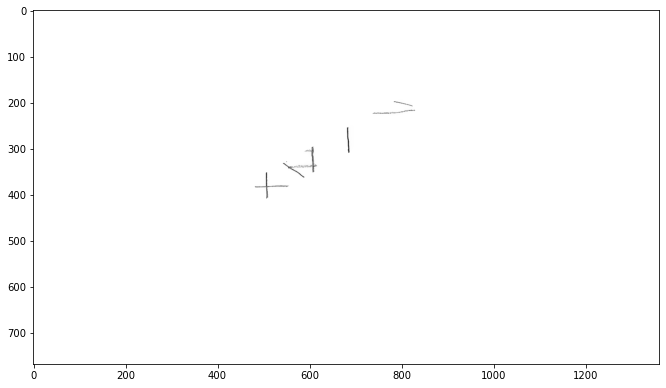

[(746, 187), (531, 373), (563, 409), (778, 223)]


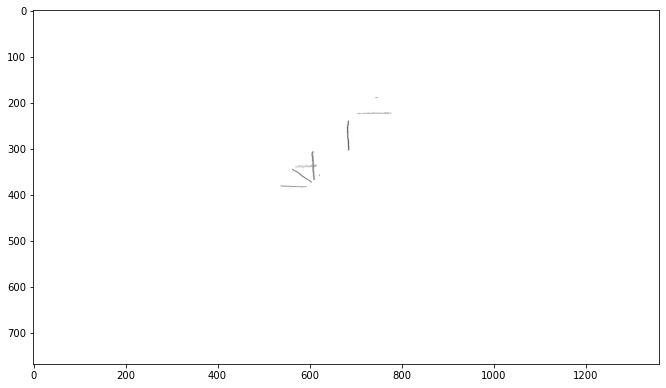

[(758, 185), (483, 371), (511, 411), (786, 225)]


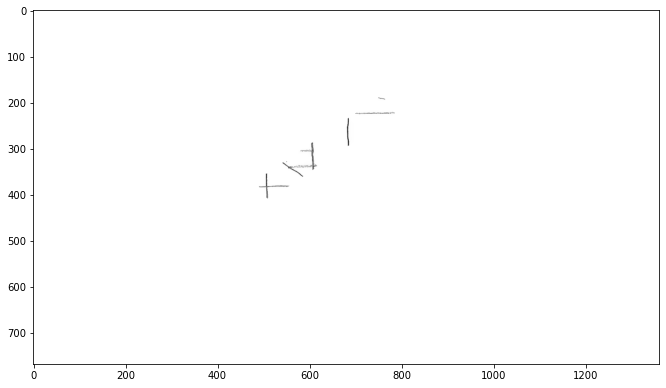

[(790, 184), (455, 370), (479, 412), (814, 226)]


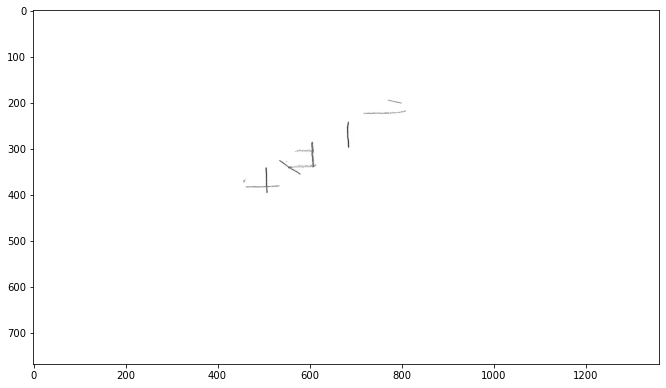

[(726, 187), (511, 373), (543, 409), (758, 223)]


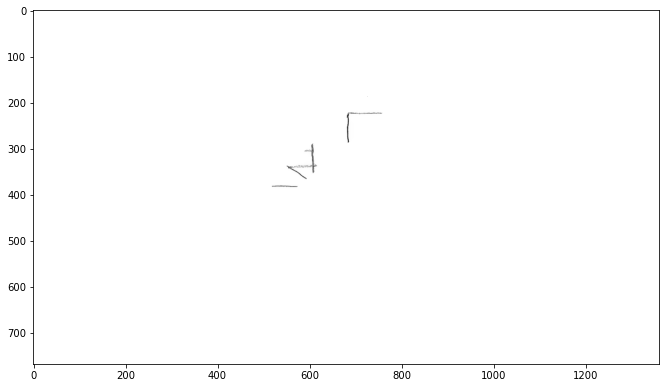

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
coverage 83.82838283828383 72.12389380530973
coverage 78.55153203342618 79.3859649122807
coverage 95.1417004048583 69.36936936936937
coverage 91.74917491749174 78.76106194690266
coverage 66.01671309192201 66.66666666666666
coverage 77.32793522267207 55.85585585585585
coverage 70.95709570957096 61.94690265486725
coverage 48.74651810584958 47.80701754385965
coverage 49.797570850202426 36.03603603603604
coverage 11.142061281337048 9.649122807017543
draw_contours______________


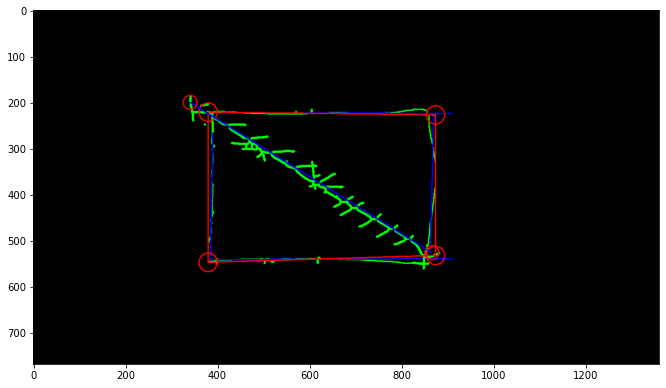

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


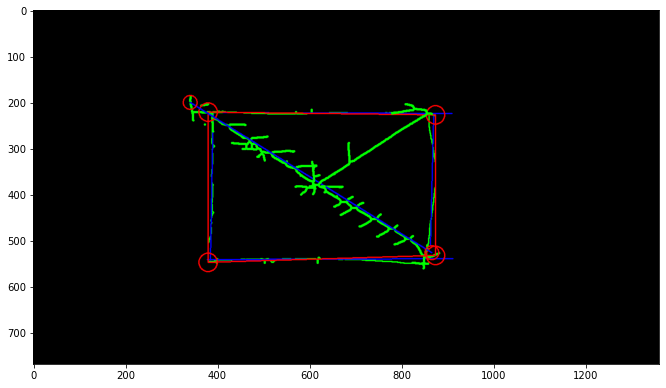

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


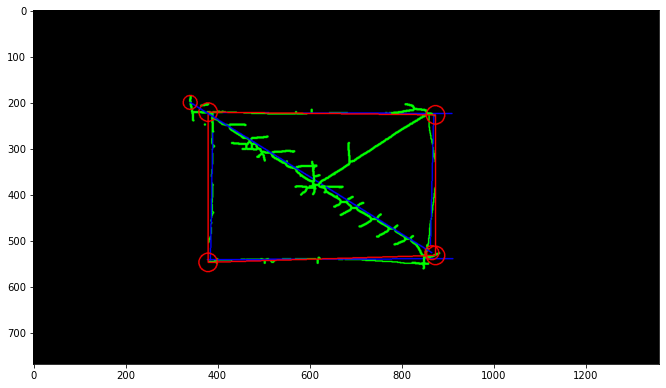

arctan2 + rad2deg -32.776873206087146
[(623, 344), (348, 530), (376, 570), (651, 384)]


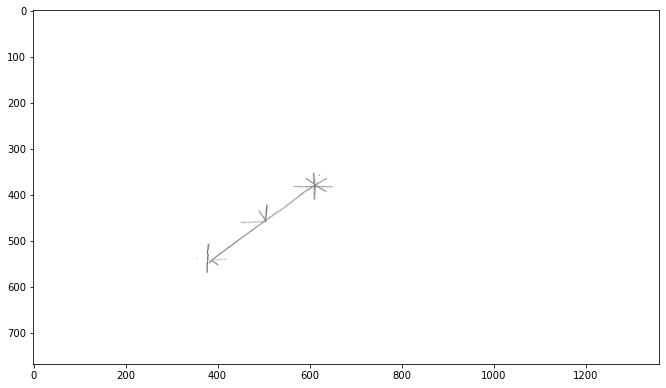

[(655, 343), (320, 529), (344, 571), (679, 385)]


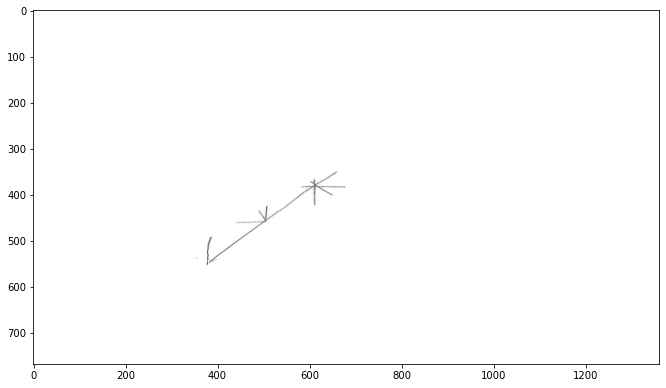

[(591, 346), (376, 532), (408, 568), (623, 382)]


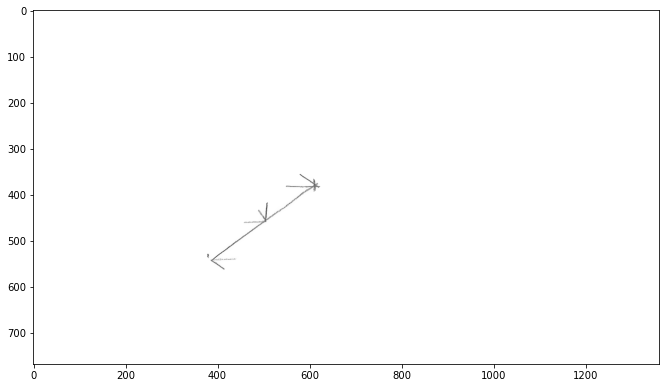

[(603, 344), (328, 530), (356, 570), (631, 384)]


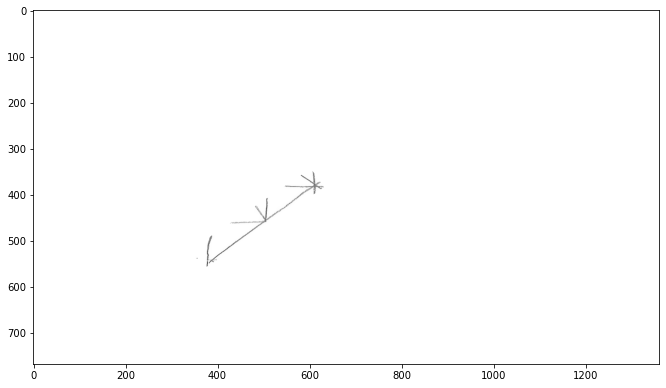

[(635, 343), (300, 529), (324, 571), (659, 385)]


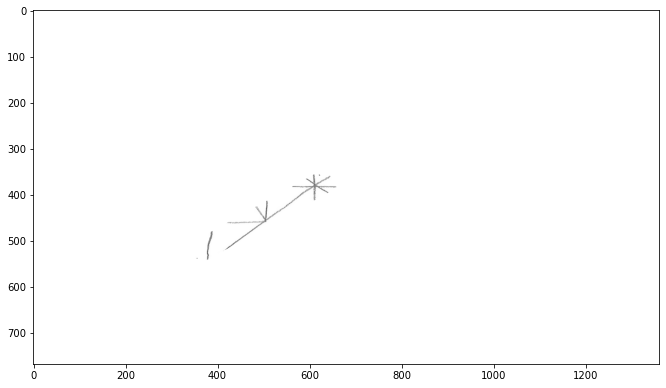

[(571, 346), (356, 532), (388, 568), (603, 382)]


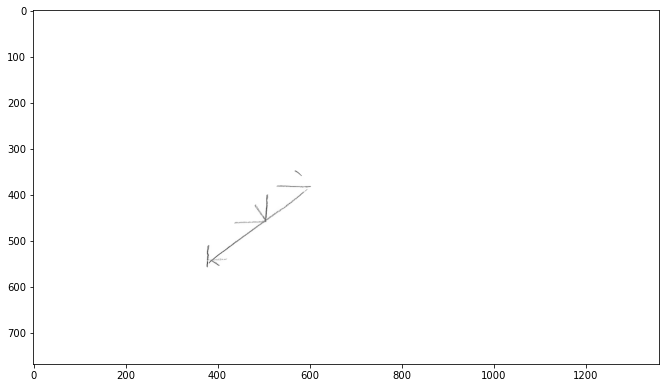

[(583, 344), (308, 530), (336, 570), (611, 384)]


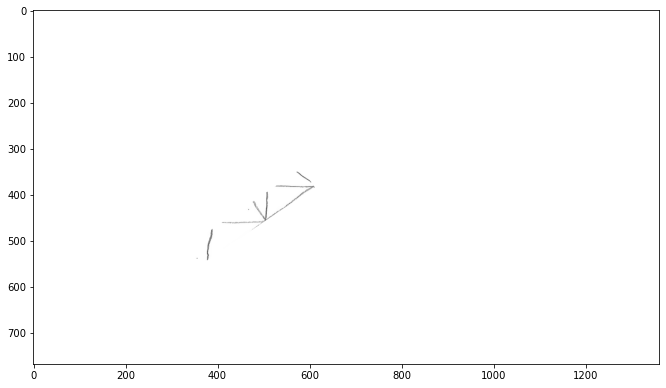

[(615, 343), (280, 529), (304, 571), (639, 385)]


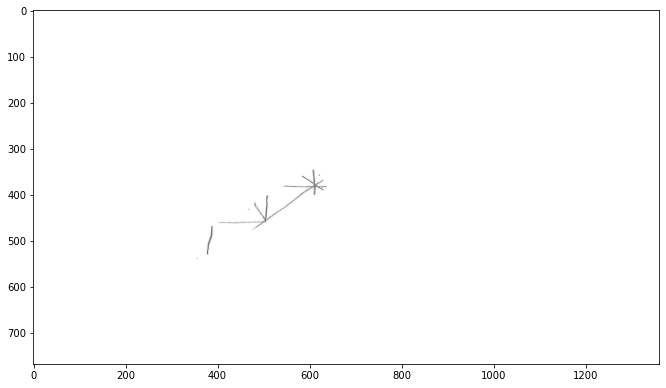

[(551, 346), (336, 532), (368, 568), (583, 382)]


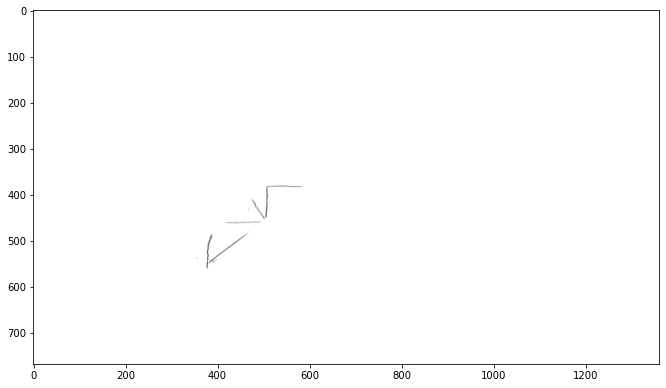

[(563, 344), (288, 530), (316, 570), (591, 384)]


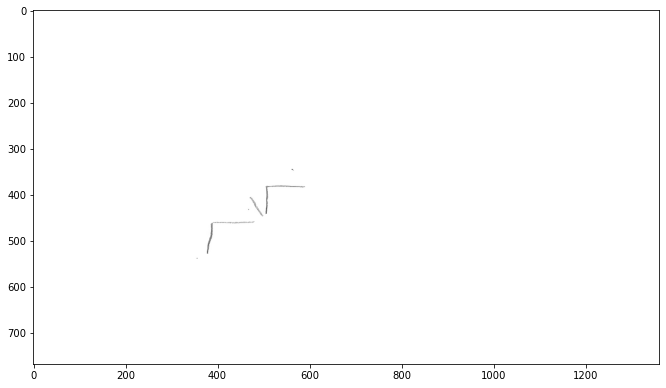

[(595, 343), (260, 529), (284, 571), (619, 385)]


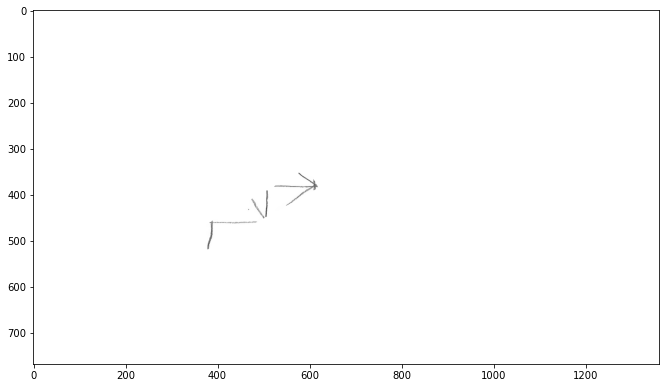

[(531, 346), (316, 532), (348, 568), (563, 382)]


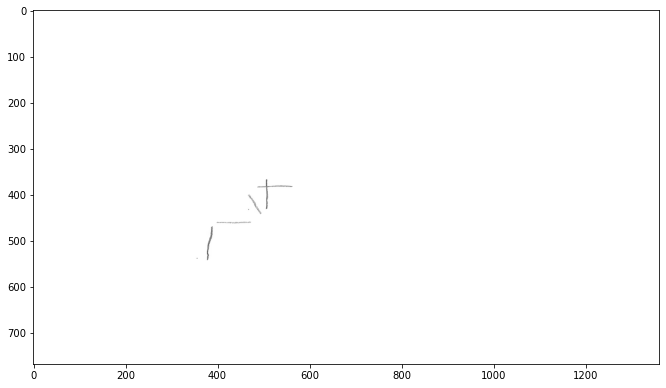

[(543, 344), (268, 530), (296, 570), (571, 384)]


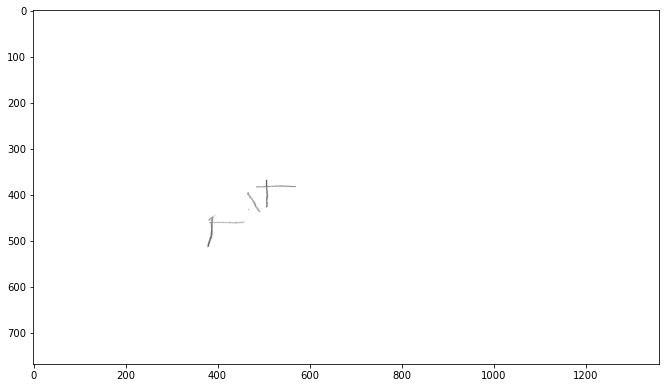

[(575, 343), (240, 529), (264, 571), (599, 385)]


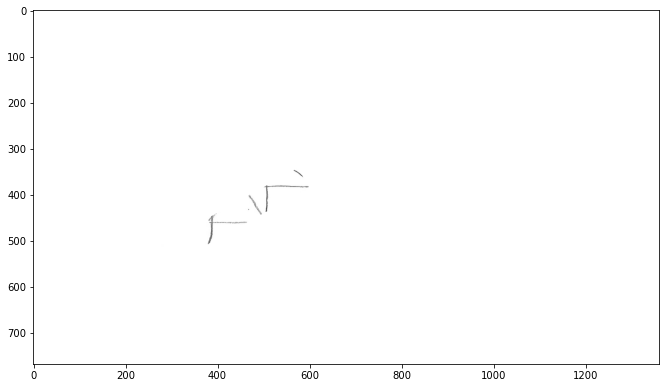

[(511, 346), (296, 532), (328, 568), (543, 382)]


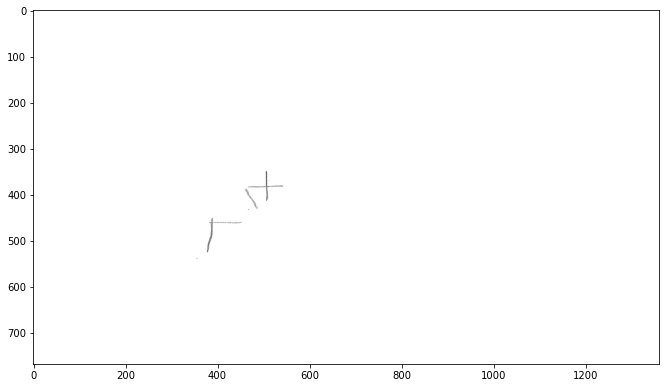

[(523, 344), (248, 530), (276, 570), (551, 384)]


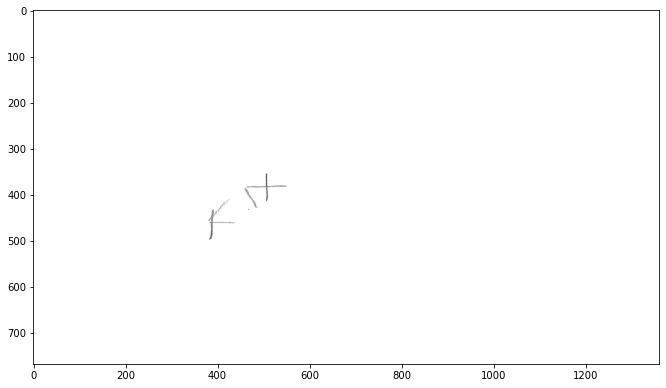

[(555, 343), (220, 529), (244, 571), (579, 385)]


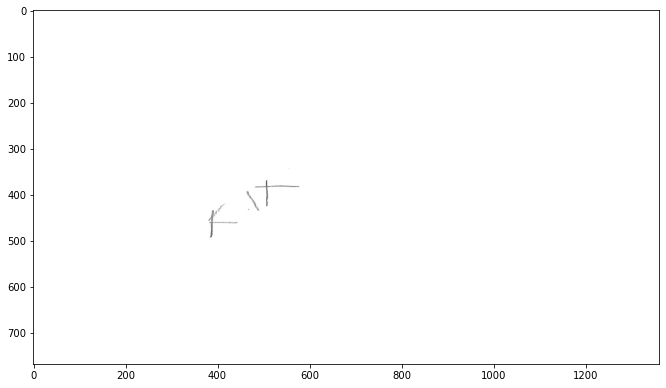

[(491, 346), (276, 532), (308, 568), (523, 382)]


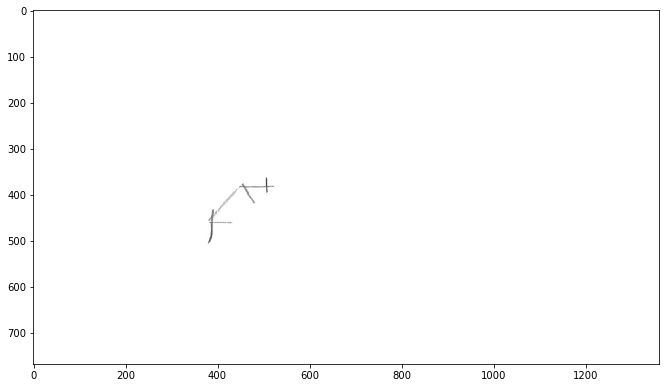

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
coverage 78.21782178217822 75.66371681415929
coverage 78.27298050139275 87.71929824561403
coverage 91.90283400809717 74.32432432432432
coverage 81.51815181518151 80.08849557522124
coverage 61.00278551532033 67.98245614035088
coverage 87.4493927125506 72.52252252252252
coverage 45.87458745874587 42.92035398230089
coverage 43.73259052924791 47.80701754385965
coverage 38.8663967611336 33.78378378378378
coverage 17.270194986072422 21.052631578947366
coverage 13.2013201320132 17.699115044247787
coverage 24.291497975708502 29.27927927927928
draw_contours______________


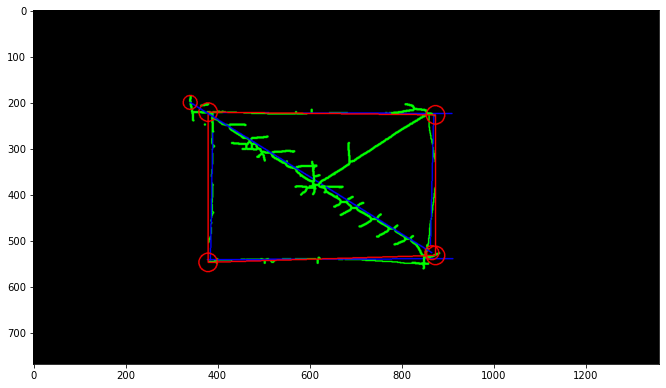

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


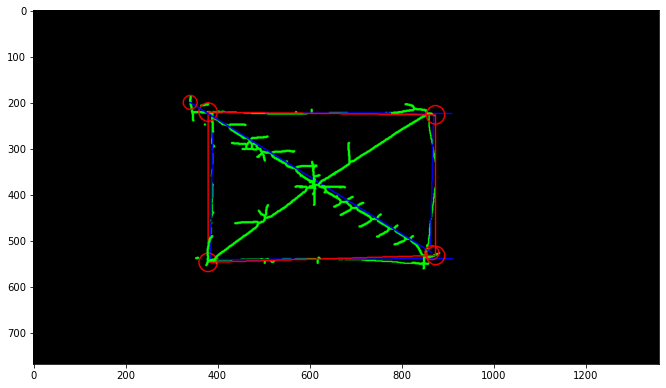

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


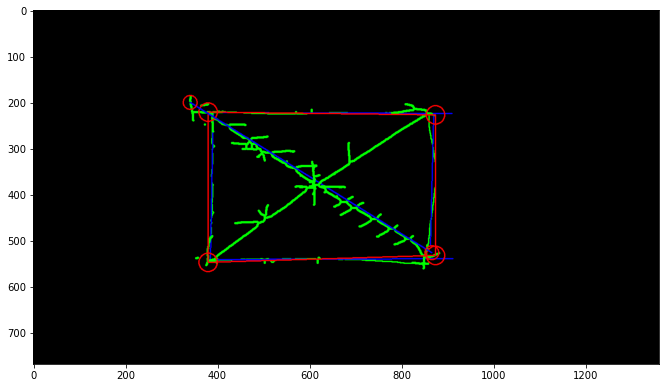

arctan2 + rad2deg -35.30555571480582
PATTERN1: angolo alto a sx wrong


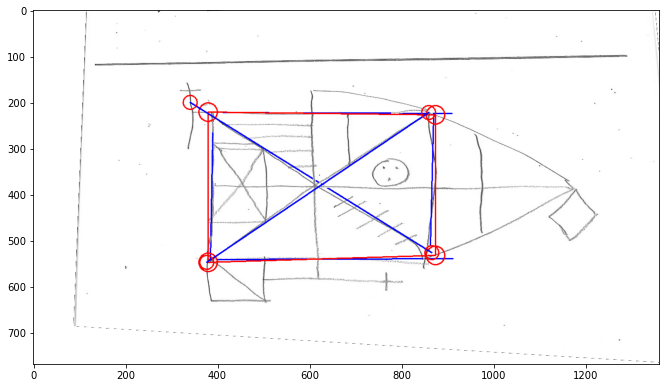

[2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
import ast
def to_tuple(t):
    return ast.literal_eval(t)

def label_conv(s):
    if s == 'NORMALI':
        return 0
    if s == 'MCI':
        return 1
    if s == 'DEMENZA':
        return 2

root = '../' 
hom_folder = os.path.join(root, 'new_sample')

#read data about tests from Database completo .csv
labels = pd.read_csv('../Database completo .csv', header=0, index_col=0, delimiter=';')

#save the pattern list 
pattern_list = labels.columns.values[3:-1]
print(pattern_list)

#set the size of the plot figure
plt.rcParams['figure.figsize'] = [12, 6.5]

#read the name of the homogram files, with the points that represent the delimitation of the 5 points of interest  
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

#guesses = []
sys_results = []
result_csv = {}
names = []
count = 0

#iterate over image paths in "../new_sample"
for img_path in os.listdir(hom_folder):
    #if the current image path has the .png extension
    if img_path.endswith('.png'):      
        #names.append(name)
        #select the name of the image by removing the last 4 chatacters, so without the extension
        name = img_path[:-4]
        #add the name in the list of names
        names.append(name)
        print(img_path)
        #show the image
        # plt.imshow(img, cmap='gray')
        # plt.show()        

        # identify the patterns in the image
        results = find_line(img_path)


        #scores = labels.loc[name][pattern_list].to_numpy()   
        #wrong_guesses = np.logical_not(np.equal(results, scores))
        #print('wrong guesses = {}'.format(pattern_list[wrong_guesses]))
        #print('my result vs. actual results = {}'.format(list(zip(tuple(results[np.nonzero(wrong_guesses)]), tuple(scores[np.nonzero(wrong_guesses)])))))
        #print(labels.loc[name][pattern_list])
        #guesses.append(np.column_stack((results, scores)))        
        #sys_results.append(results)
        
        print(results)
        sys_results.append(results)
        break
        '''if not count % 10:
            right_guess = np.array([[guess[0]==guess[1] for guess in guess_t] for guess_t in guesses])
            for template in range(right_guess.shape[1]):
            print('accuracy {}: {}'.format(pattern_list[template], np.sum(right_guess[:, template])*100/right_guess.shape[0]))'''





        

In [9]:
sys_results

[array([2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)]

Ignora da qui in poi

In [10]:
# new_df = pd.DataFrame(data=sys_results,
#                       index=names,
#                       columns=pattern_list)
# new_df.to_csv('../nuovi_result.csv')